In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

-------------------this is a self implementation of the learned logistic regression classifier---------------

Loading Data from the given Dataset is Step 0

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes  = load_dataset() #all things unpacked.

In [3]:
# # Loading the data (cat/non-cat)
# train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [4]:
train_set_x_orig.shape , test_set_x_orig.shape, test_set_y.shape # y(ground truth labels are stored as row vectors)

((209, 64, 64, 3), (50, 64, 64, 3), (1, 50))

In [5]:
#test_set_x_orig.shape #images are not kept the way you are thinking them they are kept.

In [6]:
train_set_x_orig[101].shape

(64, 64, 3)

y = [0], its a non-cat image


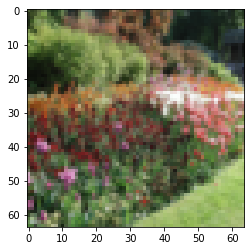

In [7]:
image_I = 101;
plt.imshow(train_set_x_orig[image_I])
print("y = "+ str(train_set_y[:,image_I]) + ", its a " + str(classes[np.squeeze(train_set_y[:, image_I])].decode("utf-8"))+ " image")

In [8]:
# # Example of a picture
# index = 3
# plt.imshow(train_set_x_orig[index]) #plt.imshow always takes an image in the defined dimesions i.e as a 3D ARRAY.
# print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [9]:
classes[0].decode("utf-8"), classes[1].decode("utf-8")

('non-cat', 'cat')

num_px (= height = width of a training image), image_dims = (num_pxs, num_pxs, number of channels)

In [10]:
#finding the numbers.

m_train = train_set_x_orig.shape[0]  # number of training examples.
m_test  = test_set_x_orig.shape[0]   # number of testing examples.
num_px  = train_set_x_orig.shape[1] # height = width = number of pixles along height/width of an image.

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape)) #a row vector.
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape)) #a row vector.

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Preprocessing the Dataset, the 'y' part does not require preprocessing.

In [11]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T #x part of training set.
test_set_x_flatten  = test_set_x_orig.reshape(m_test, -1).T # preprocessed x part of test data.


print("train_set_x_flatten shape "+ str( train_set_x_flatten.shape))
print("train_set_y "+ str( train_set_y.shape))
print("test_set_x_flatten shape "+ str( test_set_x_flatten.shape))
print("test_set_y shape"+ str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0])) #what is this sanity check.

train_set_x_flatten shape (12288, 209)
train_set_y (1, 209)
test_set_x_flatten shape (12288, 50)
test_set_y shape(1, 50)
sanity check after reshaping: [17 31 56 22 33]


standardazing our dataset, meaning

1. substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array.

2. for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [12]:
train_set_x = train_set_x_flatten/255 #turns out dividing the values of the each image feature with 255 does not affect it anyway. the image stays the same.
test_set_x  = test_set_x_flatten/255

#### Preprocessing complete.

#### Steps involved were.
1. finding out dimensions of the problem, (m_train, m_test, num_pxs)
2. reshape the dataset such that each example is a column vector with shape (num_pxs*num_pxs*3,1)
3. standardize the data.

###                                               General Architecture of the Model

##### Mathematical Expressions .

##### For one training example
 
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$
 
 Cost Computed over entire training set        
 
  J(w,b)   = -1/m * ( L(y^(1), y(1)) + L(y^(2), y(2)) + L(y^(3), y(3)) + .... + L(y^(m),y(m)) )
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

#### Steps involved in creating the model.

 1. initialise the parameters of the model.
 2. learn the parameters by minimising the cost. (make use of gradient descent)
 3. Use the learned parameters to predict values for test set.
 4. analyse the results.

## 4 - Building the parts of our algorithm ## 


##### Main Steps for building the Neural Network are.

1. Define the model structure ( i.e number of input features )
2. initialise the model parameters. ( we can begin with one round of forward propagation with these value )
3. Loop.
        
        Calculate current loss ( forward propagation )
        Calculate current gradient ( backward propagation,calculating gradients of final_out_var wrt other vars)
        Update the parameters. (gradient descent part)

In [13]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [14]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.ones((dim,1))
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

### 4.3 - Forward and Backward propagation



Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$  (for the entire training set)
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Calculation of the Gradients 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$



In [15]:
def propagate(w,b,X,Y):
    
    '''
    arguments: 
    
     w: weights matrix of shape (num_px * num_px * 3, 1) ->a column vector.
     b: a scalar bias
     X: training data of shape (num_px * num_px * 3, num_examples)
     Y: true labels associated with each image present in the X matrix. a row vector of shape (1, num_examples)
     
    '''
    assert(w.shape == (X.shape[0],1))

    # caclualtion of the cost function.
    m = X.shape[1]                                  # number of training examples in X dataset 
    
    A = sigmoid(np.dot(w.T,X) + b)                  # activations of the output unit of logistic regression
    
    _loss =  Y*np.log(A) + (1-Y)*np.log(1-A) 
    assert(_loss.shape == (Y.shape))
    
    cost = (-1/m)* np.sum(_loss)                    # cost func for given w and b.
    
    #calculation of the gradients.
    dw = np.dot(X,(A-Y).T) / m
    db = np.sum(A-Y) / m
    
    grads = {"dw":dw, "db":db}
    
    return grads, cost

#### Optimization

 Values are to be learnt for w and b using gradient descent (by minimizing the cost)
 

In [16]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations): #in one iteration one update is done to the values of w and b.
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w,b,X,Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads # wont these variables go out of scope, how are they returned.
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate* db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [17]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]]) #too large value of weights gives nan cost.
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


In [18]:

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = np.reshape(w,(X.shape[0], 1)) #this is redundant 
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if(A[0][i]<=0.5): 
            Y_prediction[0][i] = 0
        else:
            if(A[0][i]>0.5):
                Y_prediction[0][i] = 1
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [19]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    
    w, b = np.zeros((X_train.shape[0],1)), 0. # a column vector
    print(w.shape)
    

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost) 
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

#####                                                               Training Our Model  

In [20]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

(12288, 1)
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


In [31]:
y_predictions_test = d["Y_prediction_test"]
y_predicitons_train = d["Y_prediction_train"]
y_actual_test = test_set_y
y_actual_train = train_set_y

In [32]:
np.mean(abs(y_predicitons_train - y_actual_train))

0.009569377990430622

y = 0, you predicted y =  "1.0


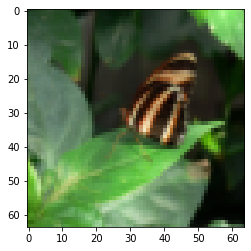

In [35]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted y =  \"" + str(d["Y_prediction_test"][0,index])) 

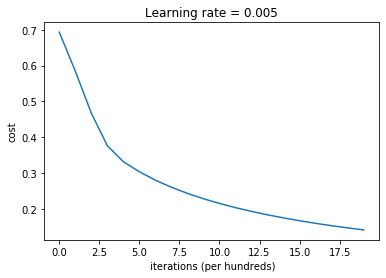

In [72]:
costs = d["costs"]
costs = np.squeeze(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel(' iterations (per hundreds)')
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()